<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<font color=3C99D size=5>
    Practical Assignment 5 - NLP - Skip-Gram <br>
<font color=0CBCDF size=4>
   &#x1F335; Amirhossein Akbari  &#x1F335;
</div>

____

<font color=9999FF size=4>
&#x1F388; Full Name : Alireza Mirrokni
<br>
<font color=9999FF size=4>
&#x1F388; Student Number : 401106617

<font color=0080FF size=3>
This notebook explores word embeddings, compact and dense vector representations of words that capture their textual meaning. This notebook focusing on implementing the Word2Vec algorithm using the Skip-gram architecture and negative sampling.
</font>
<br>

**Note:**
<br>
<font color=66B2FF size=2>In this notebook, you are free to use any function or model from TensorFlow to assist with the implementation. However, PyTorch is not permitted for this exercise. This ensures consistency and alignment with the tools being focused on.</font>
<br>
<font color=red size=3>**Run All Cells Before Submission**</font>: <font color=FF99CC size=2>Before saving and submitting your notebook, please ensure you run all cells from start to finish. This practice guarantees that your notebook is self-consistent and can be evaluated correctly by others.</font>

<font color=#ffb578 size=3>
you are free to modify, add, or remove any cells as you see fit to complete your tasks. Feel free to change any of the provided code or content to better suit your understanding and approach to the problems.

- **Questions**: If you have any questions or require clarifications as you work through the notebook, please do not hesitate to ask. You can post your queries on Quera or reach out via Telegram.
- **Feedback**: We encourage you to seek feedback and engage in discussions to enhance your learning experience and improve your solutions.
</font>

In [1]:
import io
import math
import gzip
import nltk
import time
import random
import numpy as np
import tensorflow as tf
import gensim.downloader as api
import tensorflow_datasets as tfds
nltk.download('stopwords')

from collections import Counter
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Downloading Dataset
We're going to use text8 dataset. Text8 is first 100,000,000 bytes of plain text from Wikipedia. It's mainly used for testing purposes.

In [2]:
def load_data():
  text8_zip_file_path = api.load('text8', return_path=True)
  with gzip.open(text8_zip_file_path, 'rb') as file:
    file_content = file.read()
  wiki = file_content.decode()
  return wiki

wiki = load_data()

### Preprocessing data

**Stopwords removal** - Begin by removing stopwords from the dataset, as they provide little to no value in learning word embeddings. Ensure your preprocessing pipeline filters out commonly used words such as "the," "and," or "of" that do not contribute to meaningful semantic relationships.

---

**Subsampling words** - In a large corpora, most frequent words can easily occur hundreds of millions of times and such words usually don't bring much information to the table.  It is of essential importance to cut down on their frequencies to mitigate the negative impact it adds. For example, co-occurrences of "English" and "Spanish" benefit much more than co-occurrences of "English" and "the" or "Spanish" and "of". To counter the imbalance between rare and frequent words Mikolov et. al came up with the following heuristic formula for determining probability to drop a particular word:

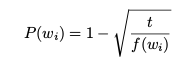

where t is threshold value (heuristically set to 1e-5) and f(w) is frequency of the word.

Implement a subsampling mechanism to handle overly frequent words in the corpus. Use the heuristic formula provided by Mikolov et al. to calculate the probability of dropping a word based on its frequency. This step ensures the corpus maintains a balance between rare and frequent words, improving the quality of word co-occurrence relationships.

---

**Filtering words** - Filter out words that occur only once in the dataset, as they lack sufficient context to be represented effectively. Retain only those words that appear at least five times in the corpus to minimize noise and enhance the overall quality of the embeddings.


In [3]:
def preprocess_text(text):
  # Step 1: Replace punctuation with tokens to standardize the text for processing
  # Example: Replace '.', ',', and other punctuation marks with specific tokens
  import re
  text = re.sub(r'[^\w\s]', '', text)

  # Step 2: Convert text to lowercase and remove unnecessary whitespaces
  # Example: Apply text.lower() and text.strip()
  text = text.lower().strip()

  # Step 3: Remove stopwords from the text
  # Example: Filter out common words such as 'the', 'and', 'of' using a predefined stopwords list
  words = text.split()
  sw = set(stopwords.words('english'))
  words = [w for w in words if w not in sw]

  # Step 4: Remove words with frequency less than 5
  # Example: Count word frequencies and filter words appearing fewer than 5 times
  word_counts = Counter(words)
  words = [word for word in words if word_counts[word] >= 5]

  # Step 5: Subsample words using a threshold value (e.g., 1e-5)
  # Example: Implement the subsampling heuristic to reduce the frequency of overly common words
  threshold = 1e-5
  total_count = len(words)
  word_freq = {word: count / total_count for word, count in word_counts.items()}
  subsample_prob = {word: 1 - np.sqrt(threshold / word_freq[word]) for word in word_counts}
  words = [word for word in words if random.random() > subsample_prob[word]]

  # Return the processed words and word counts
  word_counts = Counter(words)
  return words, word_counts

It's always a good idea to take a quick look at preprocessed sample before heading further - you might observe few things that if handled can enrich or correct your data. More like a validation step this.

In [4]:
# Take a quick look at a slice of preprocessed words (e.g., index 1500 to 1550)
preprocessed_words, word_counts = preprocess_text(wiki)

print("Total words after preprocessing:", len(preprocessed_words))
print("Sample words:", preprocessed_words[:20])

print("Sample slice (1500-1550):", preprocessed_words[1500:1550])

Total words after preprocessing: 3810349
Sample words: ['anarchism', 'originated', 'abuse', 'working', 'radicals', 'diggers', 'english', 'revolution', 'sans', 'culottes', 'revolution', 'pejorative', 'violent', 'destroy', 'positive', 'self', 'anarchists', 'derived', 'without', 'archons']
Sample slice (1500-1550): ['tendencies', 'dogmatic', 'facade', 'hypocrisy', 'sexist', 'anarchists', 'proudhon', 'bakunin', 'hypocrisy', 'anarchism', 'anarchists', 'dismiss', 'prejudices', 'beliefs', 'present', 'criticise', 'anarchism', 'continuing', 'thinkers', 'proudhon', 'fascism', 'cercle', 'proudhon', 'anarcho', 'bryan', 'caplan', 'fascists', 'suspected', 'fascist', 'sympathizers', 'spanish', 'civil', 'illegitimate', 'coercion', 'faction', 'fascists', 'criticizes', 'willingness', 'cnt', 'join', 'statist', 'republican', 'stanley', 'payne', 'claims', 'cnt', 'negotiations', 'noam', 'chomsky', 'kind']


### Hyperparameters
Setting a few hyperparamters required for gnerating batches and for deciding the size of word embeddings.



In [5]:
EMBEDDING_DIM = 64
BUFFER_SIZE = 100000
BATCH_SIZE = 2048
EPOCHS = 5

### Preparing TensorFlow Dataset using Skipgrams

**Generating Skipgrams**

Tokenize your preprocessed textual data and convert the words into their corresponding vectorized tokens. Then, use the `skipgrams` function provided by Keras to generate (word, context) pairs. Ensure the following steps are completed:

- Generate positive samples: (word, word in the same window), with label 1.  
- Generate negative samples: (word, random word from the vocabulary), with label 0.  

Refer to Mikolov et al.'s paper, [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781v3.pdf), for more details on Skipgrams.

---

**Negative Sampling**

For each input word, implement the negative sampling approach to optimize the training process. Transform the problem of predicting context words into independent binary classification tasks. For every (target, context) pair, generate random negative (target, ~context) samples. This step will reduce computational complexity and make training more efficient.


In [6]:
# Step 1: Initialize and fit the tokenizer on preprocessed words
# Tokenize the preprocessed words and create a vocabulary index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_words)
word_index = tokenizer.word_index
index_word = {v: k for k, v in word_index.items()}
vocab_size = len(word_index) + 1

# Step 2: Vectorize the words using the tokenizer's word index
# Convert the preprocessed words into vectorized tokens
sequences = tokenizer.texts_to_sequences([preprocessed_words])[0]

# Step 3: Generate skipgram pairs and labels
# Use the skipgrams function to create (word, context) pairs with their labels
window_size = 3
skip_gram_pairs, labels = skipgrams(
    sequences,
    vocabulary_size=vocab_size,
    window_size=window_size,
    negative_samples=0.7
)

# Step 4: Extract target and context words from the generated pairs
# Separate the target words and context words for training
targets, contexts = zip(*skip_gram_pairs)
targets = np.array(targets, dtype=np.int32)
contexts = np.array(contexts, dtype=np.int32)
labels = np.array(labels, dtype=np.int32)

# Step 5: Split the data into training and testing sets
# Define a sample size and divide the data into training and testing subsets
split_index = int(len(targets) * 0.9)
train_targets, val_targets = targets[:split_index], targets[split_index:]
train_contexts, val_contexts = contexts[:split_index], contexts[split_index:]
train_labels, val_labels = labels[:split_index], labels[split_index:]

# Step 6: Create TensorFlow datasets
# Prepare TensorFlow datasets for training and testing with appropriate batching and shuffling
train_dataset = tf.data.Dataset.from_tensor_slices(((train_targets, train_contexts), train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices(((val_targets, val_contexts), val_labels))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [7]:
# Print the number of batches in the training and testing datasets
print("Training batches:", len(train_dataset))
print("Testing batches:", len(test_dataset))

Training batches: 17079
Testing batches: 1897


### Building the Model

Use the model subclassing method to build your model. While Sequential and Functional APIs are generally more suitable for most use cases, model subclassing allows you to create the model in an object-oriented way. Follow these steps:

1. Define a custom model class by inheriting from `tf.keras.Model`.
2. Implement the `__init__` method to define the layers of your model.
3. Override the `call` method to define the forward pass of your model.
4. Ensure that the model includes embedding layers, a skip-gram architecture, and any other necessary components for training.


In [11]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"Using GPU: {tf.config.experimental.get_device_details(physical_devices[0])['device_name']}")
else:
    print("Using CPU")

Using GPU: Tesla T4


In [21]:
# Step 1: Create a custom model class by subclassing `tf.keras.Model`
# Define a class that inherits from the Keras Model class
class Word2Vec(tf.keras.Model):
    # Step 2: Initialize the layers in the __init__ method
    # Define all the layers such as embedding, dense, or output layers
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.target_embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        self.context_embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        self.dense = tf.keras.layers.Dense(1)

    # Step 3: Implement the forward pass in the call method
    # Define how the input data flows through the model to produce the output
    def call(self, inputs):
        target, context = inputs
        target_vector = self.target_embedding(target)
        context_vector = self.context_embedding(context)
        dot_product = tf.reduce_sum(target_vector * context_vector, axis=-1, keepdims=True)
        output = self.dense(dot_product)
        return tf.nn.sigmoid(output)

# Step 4: Ensure the model implements the skip-gram architecture
# Include logic for embedding lookups and processing positive and negative samples
model = Word2Vec(vocab_size, EMBEDDING_DIM)

# Step 5: Verify that the model structure aligns with the objective
# Test the forward pass to ensure proper layer connections and outputs
print(model.summary())

inputs = (tf.constant([[1]]), tf.constant([[2]]))
print(model(inputs))

Model: "word2_vec_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_8 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
tf.Tensor([[[0.50003034]]], shape=(1, 1, 1), dtype=float32)


### Loss function, Metrics and Optimizers

In [22]:
optimiser = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

### Training the Model

Implement custom training for learning word embeddings to gain finer control over optimization and training tasks. Follow these steps:

1. Define a custom training loop that includes forward propagation, loss computation, and backpropagation.
2. Use the optimizer of your choice to update the model's weights based on the computed gradients.
3. Implement batching for efficient data processing during training.
4. Monitor the loss during each epoch to track the model's performance.
5. Save the trained embeddings for later use once the training is complete.

In [23]:
from tqdm import tqdm

# Step 1: Define the training step
# Create a `train_step` function using `tf.GradientTape` to compute predictions, calculate loss, and apply gradients to update model weights
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss = loss_fn(y, y_pred)
    grads = tape.gradient(loss, model.trainable_variables)
    optimiser.apply_gradients(zip(grads, model.trainable_variables))
    train_acc_metric.update_state(y, y_pred)
    return loss

# Step 2: Define the testing step
# Create a `test_step` function to compute predictions and calculate validation loss without updating the model weights
@tf.function
def test_step(x, y):
    y_pred = model(x, training=False)
    loss = loss_fn(y, y_pred)
    val_acc_metric.update_state(y, y_pred)
    return loss

# Step 3: Initialize the training loop
# Set up a loop to iterate over epochs and train the model for the defined number of iterations
for epoch in range(EPOCHS):
    start_time = time.time()
    train_acc_metric.reset_state()
    val_acc_metric.reset_state()

    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_progress = tqdm(train_dataset, desc='Training')
    for x_train, y_train in train_progress:
        loss = train_step(x_train, y_train)
        train_progress.set_postfix({'Loss': loss.numpy()})

    train_acc = train_acc_metric.result()

    val_progress = tqdm(test_dataset, desc='Validation')
    for x_val, y_val in val_progress:
        val_loss = test_step(x_val, y_val)
        val_progress.set_postfix({'Val Loss': val_loss.numpy()})

    val_acc = val_acc_metric.result()
    elapsed_time = time.time() - start_time

    print(
        f" - Train Acc: {train_acc.numpy():.4f}, "
        f"Val Acc: {val_acc.numpy():.4f}, "
        f"Time: {elapsed_time:.2f}s"
    )


Epoch 1/5


Validation: 100%|██████████| 1897/1897 [00:15<00:00, 121.82it/s, Val Loss=0.439]


 - Train Acc: 0.7776, Val Acc: 0.8119, Time: 333.97s

Epoch 2/5


Validation: 100%|██████████| 1897/1897 [00:15<00:00, 122.89it/s, Val Loss=0.406]


 - Train Acc: 0.8331, Val Acc: 0.8215, Time: 332.09s

Epoch 3/5


Validation: 100%|██████████| 1897/1897 [00:15<00:00, 120.02it/s, Val Loss=0.408]


 - Train Acc: 0.8564, Val Acc: 0.8202, Time: 338.14s

Epoch 4/5


Validation: 100%|██████████| 1897/1897 [00:20<00:00, 92.63it/s, Val Loss=0.419] 


 - Train Acc: 0.8704, Val Acc: 0.8177, Time: 337.66s

Epoch 5/5


Validation: 100%|██████████| 1897/1897 [00:22<00:00, 84.69it/s, Val Loss=0.432] 


 - Train Acc: 0.8793, Val Acc: 0.8154, Time: 344.60s


In [24]:
# Save weights to a Tensorflow Checkpoint file
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.save('skipgram_model_checkpoint/ckpt')

'skipgram_model_checkpoint/ckpt-1'

### Word Embeddings Projector

Follow these steps to visualize the learned word embeddings using TensorFlow's Embedding Projector:

1. Extract the weights of the embedding layer from your trained model.
2. Save the weights into two files:
   - `vecs.tsv`: This file will store the actual vector representations of words.
   - `meta.tsv`: This file will store the associated metadata (e.g., word labels) for visualization.
3. Go to [TensorFlow Embedding Projector](http://projector.tensorflow.org/).
4. Upload the `vecs.tsv` and `meta.tsv` files created in the previous step.
5. Explore the visualizations provided by TensorFlow's Embedding Projector.
<font color=#ffb578>
6.Save the visualization of a word that best demonstrate the quality of your embeddings as an image and store it near the notebook.
7. Compress the folder into a `.zip` file and submit it as part of your work.

</font>


In [27]:
# Step 1: Access the embedding layer from the trained model
# Retrieve the first layer (embedding layer) from the model
embeddings = model.target_embedding.get_weights()[0]

# Step 2: Extract the weights from the embedding layer
# Get the weights (word embeddings) as a NumPy array
print(f"Embedding shape: {embeddings.shape}")

# Step 3: Open files to store embeddings and metadata
# Create two files - 'vecs.tsv' for embeddings and 'meta.tsv' for word metadata
with open('vecs.tsv', 'w') as vec_file, open('meta.tsv', 'w') as meta_file:
    # Step 4: Iterate through the tokenizer's vocabulary
    # For each word in the vocabulary, write its metadata and embeddings to the files
    for word, idx in tokenizer.word_index.items():
        if idx < vocab_size:  # Ensure index is within vocabulary size
            vector = embeddings[idx]  # Adjusted index handling to directly access embeddings
            vec_file.write('\t'.join([str(x) for x in vector]) + '\n')
            meta_file.write(word + '\n')

# Step 5: Close the files after writing
# Ensure that the files are properly saved and closed
vec_file.close()
meta_file.close()

Embedding shape: (71141, 64)
